## Evolution / Genetic Algorithm exercise

In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

### [Buckling](https://en.wikipedia.org/wiki/Buckling)

#### For a pinned beam (simple pin at each end), what are the optimal dimensions and rigidity for a fixed length beam? 
#### *(Optimize for reduced buckling - maximum critical force)* $\rightarrow$ todo: include lowest mass in fitness function

Given by:

*F* = $\frac{\pi^2E I}{(KL)^2}$

    F = maximum or critical force (vertical load on column),
    E = modulus of elasticity,
    I = smallest area moment of inertia of the cross section of the column,
    L = unsupported length of column,
    K = column effective length factor, whose value depends on the conditions of end support of the column, as follows.
        For both ends pinned (hinged, free to rotate), K = 1.0.

With pinned ends and fixed length, the equation reduces to:

*F* = CEI, where C is a constant, ($\frac{\pi}{L}$)<sup>2</sup>

The moment of inertia, *I*, is given by:

I = $\frac{\pi}{4}$(r<sup>4</sup><sub>outer</sub> - r<sup>4</sup><sub>inner</sub>)

So, the final function can be given by:

*F* = CE(r<sup>4</sup><sub>outer</sub> - r<sup>4</sup><sub>inner</sub>), where C is a constant, $\frac{\pi^3}{4L^2}$

---

### Initialize population and range of gene values

In [3]:
popl = 5
elasticity = np.random.choice(range(2,650), popl)# Modulus of Elasticity for plastic through tungsten carbide ~ roughly
radius_o = np.random.choice(range(2, 100), popl) # mm
radius_i = np.array([r - np.random.choice(r-1, 1) for r in radius_o]).flatten()
length = 400 ## fixed length mm

In [4]:
def get_nucs():
    return ['E', 'ro', 'ri']

In [5]:
def get_gene_bounds():
    return {
        'E': (2, 650),
        'ro': (1,100),
        'ri': (0, 99)
    }

In [6]:
elasticity_f = lambda : np.random.choice(range(2, 650), 1)[0]
radius_o_f = lambda : np.random.choice(range(2,100), 1)[0]
radius_i_f = lambda r: (r - np.random.choice(r-1, 1)[0])

In [7]:
elasticity_f(), radius_o_f(), radius_i_f(radius_o_f())

(485, 47, 31)

In [8]:
# Define nucleotides
nucs = get_nucs()
# Define genes - zipping nucleotide names with each gene value
genes = [dict(zip(nucs, (e, ro, ri))) 
         for (e, ro, ri) in zip(elasticity, radius_o, radius_i)]

# Assign integer id for each individual in the population
population = dict(zip(range(popl), genes))
population

{0: {'E': 187, 'ri': 10, 'ro': 19},
 1: {'E': 271, 'ri': 38, 'ro': 77},
 2: {'E': 181, 'ri': 57, 'ro': 70},
 3: {'E': 399, 'ri': 10, 'ro': 77},
 4: {'E': 27, 'ri': 34, 'ro': 35}}

In [9]:
def generate_individual():
    # Define nucleotides
    nucs = get_nucs()
    E_, ro_ = elasticity_f(), radius_o_f()
    ri_ = radius_i_f(ro_)
    genes = dict(zip(nucs, (E_, ro_, ri_)))
    return genes

In [10]:
def generate_population(pop_size):
    individuals_ = dict()
    for i in range(pop_size):
        individuals_[i] = generate_individual()
        
    return individuals_

In [11]:
generate_individual()

{'E': 98, 'ri': 14, 'ro': 86}

In [12]:
generate_population(5)

{0: {'E': 69, 'ri': 86, 'ro': 89},
 1: {'E': 245, 'ri': 81, 'ro': 91},
 2: {'E': 592, 'ri': 4, 'ro': 55},
 3: {'E': 216, 'ri': 7, 'ro': 19},
 4: {'E': 590, 'ri': 17, 'ro': 68}}

---

### Define fitness

In [13]:
def fitness(individual_):
    global length
    """ Define fitness function for individuals - Buckling Force """
    C = (np.pi ** 3) / (4 * (length ** 2))
    E = individual_['E']
    ro = individual_['ro']
    ri = individual_['ri']
    F_cr = C * E * (ro**4 - ri**4)/(1000**2) # N => kg m/s^2
    
    vol = length * np.pi * (ro**2 - ri**2) / (1000**3) # m^3
    inv_vol = 0 if vol == 0 else 1/vol
    
    return 0.5 * F_cr + 0.5 * inv_vol
    

In [14]:
def check_all_fitness(individuals_):
    """ Check fitness of all individuals in population """
    return [fitness(indv) for (_, indv) in individuals_.items()]

In [15]:
check_all_fitness(generate_population(5))

[233.96392736713184,
 8841.941309805485,
 76.93394780418959,
 258.8810012507502,
 0.0]

---

### Define mutation

In [16]:
# This needs to be refactored. This only serves as an implementation of a constraint, but the constraint
# belongs to the original designation of gene values
def check_constraint(nuc_, gene_val):
    output = gene_val
    mn, mx = get_gene_bounds()[nuc_]
    if gene_val < mn:
        output = mn
    elif gene_val > mx:
        output = mx
    
    return output

In [17]:
def mutate(individual_):
    factor = np.random.choice([0.8,0.9,1,1.1,1.2], 1)[0]
    mutated = {nuc:check_constraint(nuc, factor*gene) for (nuc, gene) in individual_.items()}
#     mutated = generate_individual() # Nope
    return mutated

In [18]:
mutate(population[2])

{'E': 162.9, 'ri': 51.300000000000004, 'ro': 63.0}

---

### Define breeding

In [19]:
def breed(indv_A, indv_B):
    new_genes = {nuc:np.mean([indv_A[nuc], indv_B[nuc]])
                 for nuc in get_nucs()}
    return new_genes

In [20]:
breed(population[0],population[1])

{'E': 229.0, 'ri': 24.0, 'ro': 48.0}

In [21]:
def set_parents(individuals_):
    parents = list()
    for i in range(0, len(population)-2, 2):
        parents.append([individuals_[i], individuals_[i+1]])        
    return parents

In [22]:
set_parents(population)

[[{'E': 187, 'ri': 10, 'ro': 19}, {'E': 271, 'ri': 38, 'ro': 77}],
 [{'E': 181, 'ri': 57, 'ro': 70}, {'E': 399, 'ri': 10, 'ro': 77}]]

In [23]:
# There could be another way to breed / create next population. 
# Instead of including parents, create more children with different 
# combinations of parents' genes and only use children for next population.
def breed_population_paired(individuals_):
    
    pop_size = len(individuals_)
    # Sort individuals by fitness
#     fitnesses = check_all_fitness(individuals_)
#     fit_indv = list(zip(fitnesses, individuals_))
#     sort_fit_indv = sorted(fit_indv, reverse=True)
#     survived = [individuals_[i] for (fit, i) in sort_fit_indv]

    survived = sorted(individuals_.values(), 
                      key=lambda ind: fitness(ind), 
                      reverse=True)
    
    parents = set_parents(survived)
    children = list()
    for couple in parents:
        
        child = breed(*couple)
        if np.random.randint(100) <= 50:
            child = mutate(child)
            
        children.append(child)
        
    # Population now consists of survivors and their children
    population = survived + children
    
    # Population control
    new_pop = np.random.choice(population, pop_size)
    
    return dict(zip(range(len(new_pop)), new_pop))

In [24]:
breed_population_paired(population)

{0: {'E': 107.0, 'ri': 22.0, 'ro': 27.0},
 1: {'E': 181, 'ri': 57, 'ro': 70},
 2: {'E': 187, 'ri': 10, 'ro': 19},
 3: {'E': 181, 'ri': 57, 'ro': 70},
 4: {'E': 226.0, 'ri': 47.5, 'ro': 73.5}}

---

### Perform Simulation and see how fitness changes

In [25]:
def simulate_evolution(n_individuals, n_generations=1000):
    individuals_ = generate_population(n_individuals)
    fitnesses_ = list()
    last_fit = 0
    max_count = 50
    count = 0
    for _ in range(n_generations):
        individuals_ = breed_population_paired(individuals_)
        curr_fit = np.max(check_all_fitness(individuals_))
        fitnesses_.append(curr_fit)
        
        #check for static fit value
        if curr_fit == last_fit:
            count += 1
        else:
            count = 0
        last_fit = curr_fit
            
        if count == max_count:
            break
                
    return individuals_, fitnesses_

In [26]:
individuals, fitnesses = simulate_evolution(100, 5000)

In [27]:
print("The fittest individual is ", individuals[np.argmax(check_all_fitness(individuals))])

The fittest individual is  {'ri': 0.6085746942105601, 'E': 22.76069356347496, 'ro': 1.0}


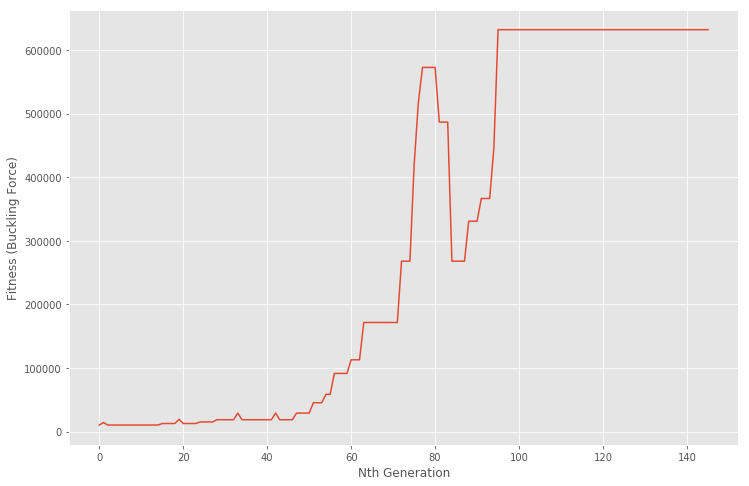

In [28]:
plt.plot(fitnesses)
plt.xlabel("Nth Generation")
plt.ylabel("Fitness (Buckling Force)")
None

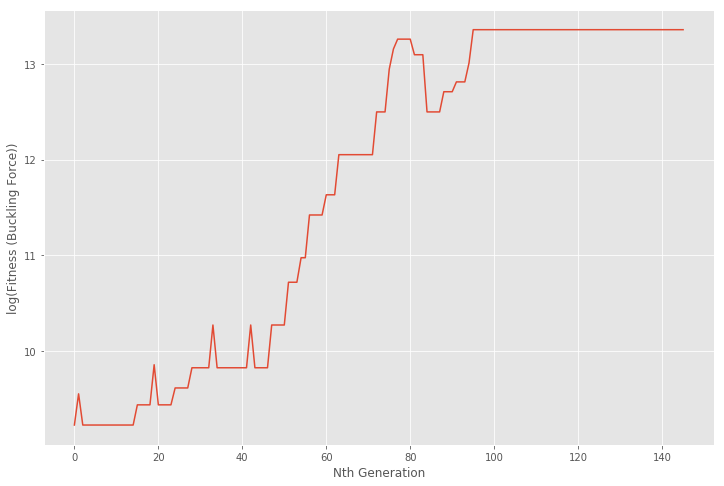

In [29]:
plt.plot(np.log(fitnesses))
plt.xlabel("Nth Generation")
plt.ylabel("log(Fitness (Buckling Force))")
None

---

In [30]:
class Individual:
    
    def _get_nucs(self):
        pass
    
    def get_genes(self):
        pass
    
    def fitness(self):
        pass


In [31]:
class Tube(Individual):
    
    elasticity_f = lambda self: np.random.choice(range(2, 650), 1)[0]
    radius_o_f = lambda self: np.random.choice(range(2,100), 1)[0]
    radius_i_f = lambda self,r: (r - np.random.choice(r-1, 1))[0]
    
    def __init__(self, length, mut_rate=0.4, elasticity=None, ro=None, ri=None):
        self.length = length
        self.mut_rate = mut_rate
        
        self.elasticity = self.elasticity_f() if elasticity is None else elasticity
        self.ro = self.radius_o_f() if ro is None else ro
        self.ri = self.radius_i_f(self.ro) if ri is None else ri
        
        self.nucs = ['E', 'ro', 'ri']
        self.genes = self._gen_genes([self.elasticity, self.ro, self.ri])
    
    def _gen_genes(self, gene_list):
        return dict(zip(self.nucs, gene_list))
    
    def set_genes(self, genes):
        self.genes = genes

    def _get_bounds(self):
        return {
            'E': (2, 650),
            'ro': (2,100),
            'ri': (1, 99) 
        }
    
    def _check_constraint(self, nuc_, gene_val):
        output = gene_val
        mn, mx = self._get_bounds()[nuc_]
        if gene_val < mn:
            output = mn
        elif gene_val > mx:
            output = mx

        return output
    
    def mutate(self):
        self._mutate_all()

    def _rand_mut_factor(self):
        return np.random.choice([0.8,0.9,1,1.1,1.2], 1)[0]
        
    def _mutate_rand(self):
        for (nuc, gene) in self.genes.items():
            if np.random.rand(len(self.nucs))[0] < self.mut_rate:
                self.genes[nuc] = self._rand_mut_factor() * gene
                
    def _mutate_all(self):
        factor = self._rand_mut_factor()
        self.genes = {nuc:self._check_constraint(nuc, factor*gene) 
                      for (nuc, gene) in self.genes.items()} 
    
    def fitness(self):
        """ Define fitness function for individuals - Buckling Force """
        C = (np.pi ** 3) / (4 * (self.length ** 2))
        E = self.elasticity
        ro = self.ro
        ri = self.ri
        F_cr = C * E * (ro**4 - ri**4)/(1000**2) # N => kg m/s^2

        vol = length * np.pi * (ro**2 - ri**2)/(1000**3) # m^3
        inv_vol = 0 if vol == 0 else (1/vol)

        return F_cr * (inv_vol)
    
    def __str__(self):
        return 'Genes: {}, Fitness: {}'.format(self.genes, self.fitness())

In [32]:
class Breeding:  
    
    def __init__(self, Individual_cls):
        self.Individual = Individual_cls
        
    def breed(self):
        pass

In [33]:
class Paired(Breeding):
    
    def breed(self, population, fit_func, pop_size):
        parents = self._set_parents(population)
        children = list()
        for (A, B) in parents:
            child = self.create_child(A, B)
            if np.random.randint(100) <= 50:
                child.mutate()

            children.append(child)

        new_pop = list(population.values()) + children
        return dict(zip(range(len(new_pop)), new_pop))
    
    def create_child(self, parent_A, parent_B):
        new_genes = {nuc:np.mean([parent_A.genes[nuc], parent_B.genes[nuc]]) 
                     for nuc in parent_A.nucs}
        child = self.Individual(parent_A.length)
        child.set_genes(new_genes)
        return child
    
    def _set_parents(self, population):
        parents = list()
        for i in range(0, len(population)-2, 2):
            parents.append([population[i], population[i+1]])        
        return parents

In [34]:
class Asexual(Breeding):
    
    def breed(self):
        pass
    

In [35]:
class GeneticAlgorithm:
    
    def __init__(self, Individual_cls, population_size, *args, **kwargs):
        self.create_individual = lambda : Individual_cls(*args, **kwargs)
        self.Individual = Individual_cls
        self.pop_size = population_size
        self.population = dict()
        self.fitnesses = list()
        
        self._breed_paired = Paired(self.Individual)
        self._breed_asexual = Asexual(self.Individual)
                
    def generate_population(self):    
        for i in range(self.pop_size):
            self.population[i] = self.create_individual()
    
    def _check_all_fitness(self):
        return [indv.fitness() for indv in self.population.values()]
    
    def get_fittest(self):
        return sorted([(indv.fitness(), indv) for indv in self.population.values()],
                      key=lambda tup: tup[0])[0]
    
    def breed(self):
        self.population = self._breed_paired.breed(self.population, 
                                                   self.Individual.fitness,
                                                   self.pop_size)

    def track_fitness(self):
        self.fitnesses.append(np.mean(self._check_all_fitness()))
        
    def select_survivors(self):
        survivors = sorted(self.population.values(), 
                           key = self.Individual.fitness, 
                           reverse=True)
        
        survivors = survivors[:self.pop_size]
        self.population = dict(zip(range(self.pop_size), survivors))
        
    def simulate_evolution(self, n_generations=1000):
        self.fitnesses = list()
        self.generate_population()
        for _ in tqdm(range(n_generations)):
            self.breed()
            self.select_survivors()
            self.track_fitness()

    def plot_fitness(self, trans = None):
        if trans is None:
            plt.plot(self.fitnesses)
            plt.xlabel('Generation')
            plt.ylabel('Fitness (Buckling Load)')
        elif trans is 'log':
            plt.plot(np.log(self.fitnesses))
            plt.xlabel('Generation')
            plt.ylabel('log(Fitness (Buckling Load))')


In [36]:
ga = GeneticAlgorithm(Tube, 100, length=40)

In [37]:
ga.simulate_evolution(1000)

100%|██████████████████████████████████| 1000/1000 [00:34<00:00, 28.69it/s]


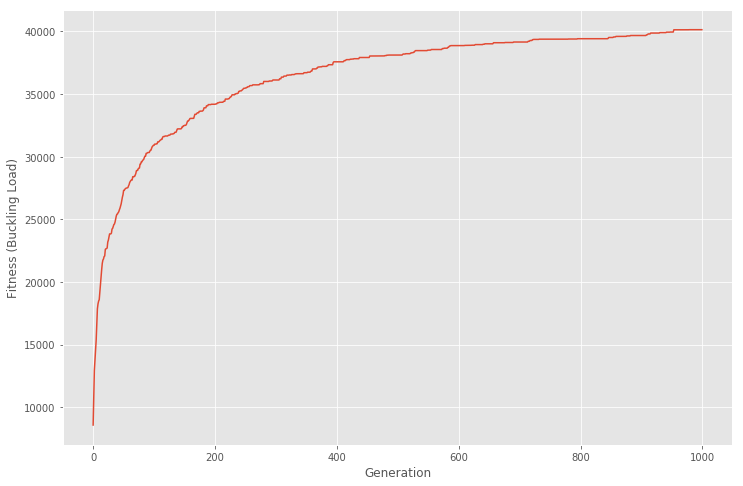

In [38]:
ga.plot_fitness()

In [46]:
def buckling(E, ro, ri, length):
    C = (np.pi ** 3) / (4 * (length ** 2))
    return C * E * (ro**4 - ri**4)/(1000**2) # N => kg m/s^2

In [40]:
def sec_mom_iner(ro, ri):
    """ expect m """
    return (ro**4 - ri**4) * (np.pi/4)

In [41]:
fittest_tube = ga.get_fittest()
fittest_genes = fittest_tube[1].genes
print(fittest_genes)

{'E': 491.16763169921876, 'ro': 80.91763146484375, 'ri': 62.3482669140625}


In [42]:
E_fit, ro_fit, ri_fit = fittest_genes['E'], fittest_genes['ro'], fittest_genes['ri']

In [43]:
fittest_tube_Fcr = buckling(E_fit, ro_fit, ri_fit, length)

In [44]:
print("The evolved tube is: ", fittest_tube[1])

The evolved tube is:  Genes: {'E': 491.16763169921876, 'ro': 80.91763146484375, 'ri': 62.3482669140625}, Fitness: 37104.507873900104


In [45]:
print("The max buckling load is: {:.3f} N".format(fittest_tube_Fcr) )

The max buckling load is: 0.661 N
